# IMPORT LIBRARIES & GLOBAL CONFIG

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pathlib import Path
import warnings

warnings.filterwarnings("ignore")
sns.set(style="whitegrid", palette="muted")
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.4f" % x)

# CONFIG

In [12]:
DATASET_NAME = "Dataset 1"
CSV_PATH = "visec_dataset.csv"
AUDIO_ROOT = r"D:\HCMUS\HK8\ML Introduction\voice\extracted"
TARGET_SR = 16000

print(f"\nPipeline setup complete for {DATASET_NAME}")
print("="*60)


Pipeline setup complete for Dataset 1


# LOADING & INITIAL CHECK

In [13]:
print(f"\n=== I. LOADING & INITIAL CHECK ({DATASET_NAME}) ===\n")

if os.path.exists(CSV_PATH):
    df = pd.read_csv(CSV_PATH)
    print(f"Loaded CSV: {CSV_PATH}")
else:
    print(f"CSV not found → generating simulated data for demo")
    df = pd.DataFrame({
        'label': ['neutral']*50 + ['angry']*30 + ['sad']*20,
        'duration': np.random.normal(3, 1, 100),
        'rms': np.random.normal(0.05, 0.01, 100),
        'frequency': [16000]*95 + [44100]*5,
        'speaker_id': ['spk1']*100
    })

print(f"-> Dataset shape: {df.shape}")
print(f"-> Columns: {list(df.columns)}")



=== I. LOADING & INITIAL CHECK (Dataset 1) ===

Loaded CSV: visec_dataset.csv
-> Dataset shape: (5280, 10)
-> Columns: ['speaker_id', 'path', 'duration', 'accent', 'emotion', 'emotion_id', 'gender', 'rms', 'frequency', 'label']


# BASIC CLEANING

In [14]:
print(f"\n=== II. BASIC CLEANING ({DATASET_NAME}) ===\n")

# Standardize labels
df["label_clean"] = df["label"].astype(str).str.lower().str.strip()
print(f"-> Unique labels: {df['label_clean'].unique()}")

# Missing values
missing_total = df.isnull().sum().sum()
print(f"-> Total missing values: {missing_total}")

# Remove duplicates
dup = df.duplicated().sum()
print(f"-> Duplicate rows: {dup}")
if dup > 0:
    df = df.drop_duplicates()


=== II. BASIC CLEANING (Dataset 1) ===

-> Unique labels: ['happy' 'neutral' 'angry' 'sad']
-> Total missing values: 0
-> Duplicate rows: 0


#  FILTER VALID AUDIO (1–15 seconds)

In [15]:
print(f"\n=== III. FILTER VALID AUDIO (1–15s) ===")

MIN_DUR = 0.5
MAX_DUR = 15.0

df_valid = df[(df["duration"] >= MIN_DUR) & (df["duration"] <= MAX_DUR)].reset_index(drop=True)
print(f"-> Remaining {len(df_valid)} files (from {len(df)})")



=== III. FILTER VALID AUDIO (1–15s) ===
-> Remaining 5277 files (from 5280)


# DESCRIPTIVE STATS (DURATION, RMS)

In [16]:
print(f"\n=== IV. DESCRIPTIVE AUDIO STATS ({DATASET_NAME}) ===")

audio_cols = ["duration", "rms"]
stats_df = pd.DataFrame(index=audio_cols, columns=["Mean", "Median", "Min", "Max", "Variance", "IQR"])

for col in audio_cols:
    stats_df.loc[col, "Mean"] = df_valid[col].mean()
    stats_df.loc[col, "Median"] = df_valid[col].median()
    stats_df.loc[col, "Min"] = df_valid[col].min()
    stats_df.loc[col, "Max"] = df_valid[col].max()
    stats_df.loc[col, "Variance"] = df_valid[col].var()
    stats_df.loc[col, "IQR"] = df_valid[col].quantile(0.75) - df_valid[col].quantile(0.25)

print("\n--- Audio Feature Statistics ---")
display(stats_df)

# Frequency check
if "frequency" in df_valid.columns:
    wrong_freq = df_valid[df_valid["frequency"] != TARGET_SR]
    print(f"\n-> Files with wrong sample rate: {len(wrong_freq)}")
    print(f"   Target SR = {TARGET_SR} Hz")


=== IV. DESCRIPTIVE AUDIO STATS (Dataset 1) ===

--- Audio Feature Statistics ---


,Mean,Median,Min,Max,Variance,IQR
duration,2.1546,1.9411,1.0000,13.5040,1.3571,0.9600
rms,0.0621,0.0404,0.0033,0.4853,0.0036,0.0656



-> Files with wrong sample rate: 0
   Target SR = 16000 Hz


# LABEL DISTRIBUTION (IMBALANCE CHECK)

In [17]:
print(f"\n=== V. LABEL DISTRIBUTION ({DATASET_NAME}) ===")

label_counts = df_valid["label_clean"].value_counts()
label_percent = label_counts / len(df_valid) * 100

print("\n-> Label percentage:")
print(label_percent)

ratio = label_counts.max() / label_counts.min()
print(f"\n-> Max/Min imbalance ratio: {ratio:.2f}")


=== V. LABEL DISTRIBUTION (Dataset 1) ===

-> Label percentage:
label_clean
neutral   28.5389
angry     27.7809
happy     23.2329
sad       20.4472
Name: count, dtype: float64

-> Max/Min imbalance ratio: 1.40


Data has the best class balance; the class proportions range from 20-28%, which is suitable for learning discriminative features without introducing bias.

# VISUALIZATION (HIST, BOX, HEATMAP)


=== VI. VISUALIZATION (Dataset 1) ===


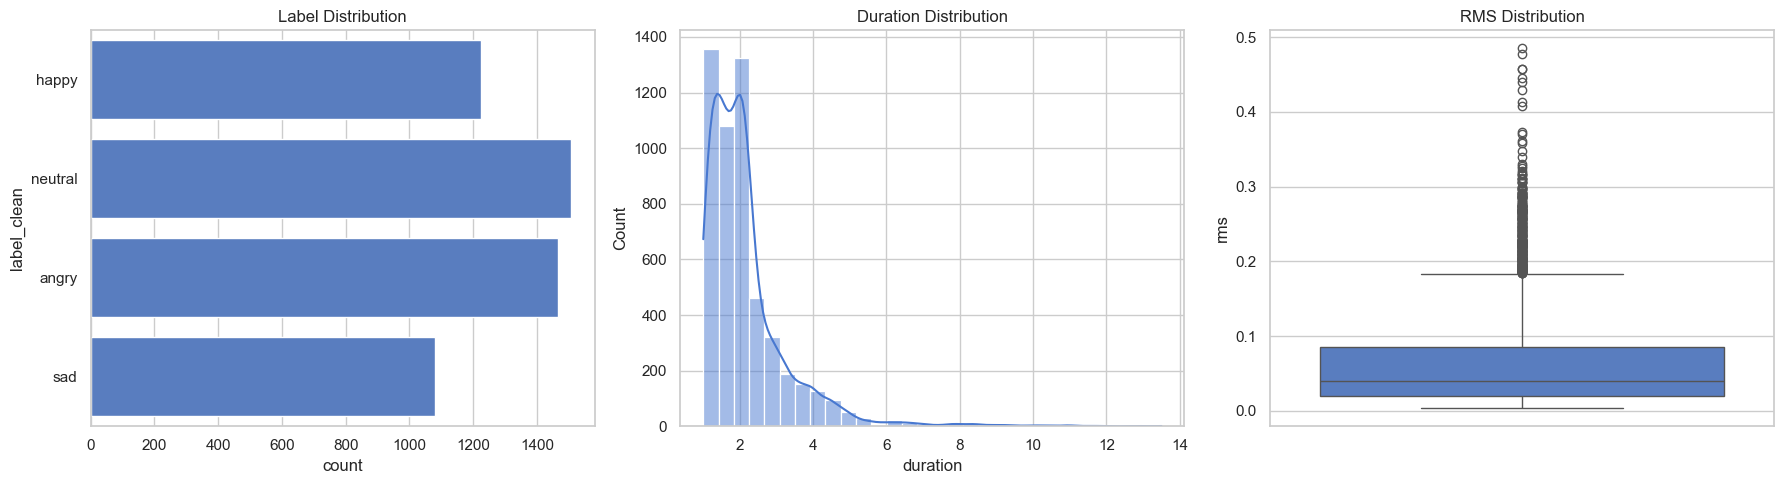

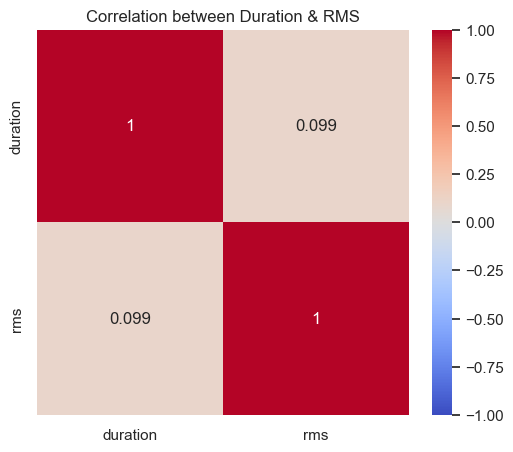


-> Variance Inflation Factor (VIF):


,Feature,VIF
0,duration,1.7930
1,rms,1.7930


In [18]:
print(f"\n=== VI. VISUALIZATION ({DATASET_NAME}) ===")

if len(df_valid) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. Label distribution
    sns.countplot(y=df_valid["label_clean"], ax=axes[0])
    axes[0].set_title("Label Distribution")

    # 2. Duration histogram
    sns.histplot(df_valid["duration"], kde=True, bins=30, ax=axes[1])
    axes[1].set_title("Duration Distribution")

    # 3. RMS boxplot
    sns.boxplot(y=df_valid["rms"], ax=axes[2])
    axes[2].set_title("RMS Distribution")

    plt.tight_layout()
    plt.show()

    # ---- Heatmap ----
    corr = df_valid[["duration", "rms"]].corr()
    plt.figure(figsize=(6, 5))
    sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title("Correlation between Duration & RMS")
    plt.show()

    # ---- VIF ----
    print("\n-> Variance Inflation Factor (VIF):")
    X_vif = df_valid[["duration", "rms"]].dropna()
    vif_table = pd.DataFrame({
        "Feature": X_vif.columns,
        "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    })
    display(vif_table)

Dataset 1 has an average duration that falls within a reasonable range and can be considered relatively balanced.

# DATA QUALITY REPORT

In [19]:
print(f"\n=== VII. DATA QUALITY REPORT ({DATASET_NAME}) ===")

missing_total = df.isnull().sum().sum()
dup_rows = df.duplicated().sum()
wrong_sr_count = len(df[df.get("frequency", TARGET_SR) != TARGET_SR])

print(f"{'Issue Type':<25} | Count")
print("-"*50)
print(f"{'Missing Values':<25} | {missing_total}")
print(f"{'Duplicate Rows':<25} | {dup_rows}")
print(f"{'Wrong Sample Rate':<25} | {wrong_sr_count}")


=== VII. DATA QUALITY REPORT (Dataset 1) ===
Issue Type                | Count
--------------------------------------------------
Missing Values            | 0
Duplicate Rows            | 0
Wrong Sample Rate         | 0


The quality of dataset is good enough for model building.